In [ ]:
# This notebook is a modification of a notebook provided by the ART Toolbox: https://github.com/Trusted-AI/adversarial-robustness-toolbox

In [ ]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tempfile
# Create a temporary directory for the model checkpoint. Remove the exising one if this cell is rerun
try:
    temp_model_dir.cleanup()
except NameError:
    print("Temporary directory not created yet")
finally:
    temp_model_dir = tempfile.TemporaryDirectory()
    print("Temporary directory:", temp_model_dir.name)

Temporary directory not created yet
Temporary directory: /tmp/tmpqgcstbl9


## Load Dataset
We will load the CIFAR10 dataset as well as define the mean and std as done in the original paper.

In [ ]:
import numpy as np
from art.utils import load_dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.201)

## Define and Train Model
We will use the modified Alexnet model from the original paper as our model to poison. We temporarily save a model checkpoint to disk. This checkpoint will be used during the finetuning step to reset the model to it's original state before the attack. For some reason, some model state variable seems to change after the attack is performed.

In [ ]:
from art.estimators.classification import PyTorchClassifier
import torch
import torch.nn as nn
import torch.optim as optim

num_classes=10
feature_size=4096
model=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        nn.Dropout(),
        nn.Linear(256 * 1 * 1, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, feature_size),
        nn.ReLU(inplace=True),
        nn.Linear(feature_size, num_classes)
)

# Define the ART Estimator
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4)
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    preprocessing=(mean, std),
    device_type='gpu'
)

In [ ]:
# Train the model

classifier.fit(x_train, y_train, nb_epochs=100, batch_size=128, verbose=True)
for param_group in classifier.optimizer.param_groups:
    print(param_group["lr"])
    param_group["lr"] *= 0.1
classifier.fit(x_train, y_train, nb_epochs=50, batch_size=128, verbose=True)
for param_group in classifier.optimizer.param_groups:
    print(param_group["lr"])
    param_group["lr"] *= 0.1
classifier.fit(x_train, y_train, nb_epochs=50, batch_size=128, verbose=True)
torch.save(model.state_dict(), temp_model_dir.name + "/htbd_model.pth") # Write the checkpoint to a temporary directory



Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

0.01


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

0.001


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 77.03999999999999%


## Generate the Poison
We now will generate the poison using the hidden trigger backdoor attack. First, we define the target and source classes as well as the backdoor trigger. The target class will be the class we want to insert poisoned data into. The source class will be the class we will add a trigger to in order to cause misclassification into the target.

The backdoor trigger will be a small image patch inserted into the source class images. At test time, we should be able to use this trigger to cause the classifier to misclassify source class images with the trigger added as the target class.

In [ ]:
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor
target = np.array([0,0,0,0,1,0,0,0,0,0])
source = np.array([0,0,0,1,0,0,0,0,0,0])

# Backdoor Trigger Parameters
patch_size = 8
x_shift = 32 - patch_size - 5
y_shift = 32 - patch_size - 5

# Define the backdoor poisoning object. Calling backdoor.poison(x) will insert the trigger into x.
from art.attacks.poisoning import perturbations
def mod(x):
    original_dtype = x.dtype
    x = perturbations.insert_image(x, backdoor_path="./htbd.png",
                                   channels_first=True, random=False, x_shift=x_shift, y_shift=y_shift,
                                   size=(patch_size,patch_size), mode='RGB', blend=1)
    return x.astype(original_dtype)
backdoor = PoisoningAttackBackdoor(mod)

Here we run the attack. `eps` controls how much the target images can be perturbed with respect to an l-infinity distance. `feature_layer` dicates with layer's output will be used to define the attack's loss. It can either be the name of the layer or the layer index according to the ART estimator. `poison_percent` controls how many poisoned samples will be generated based on the size of the input data.

The attack will return poisoned inputs of the target class and the indicies in the data that those poisoned inputs should replace.

In [ ]:
from art.attacks.poisoning import HiddenTriggerBackdoor
poison_attack = HiddenTriggerBackdoor(classifier, eps=16/255, target=target, source=source, feature_layer=19, backdoor=backdoor, decay_coeff = .95, decay_iter = 2000, max_iter=5000, batch_size=25, poison_percent=.01)

poison_data, poison_indices = poison_attack.poison(x_train, y_train)
print("Number of poison samples generated:", len(poison_data))

Hidden Trigger:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0 | i:     0 |                         LR: 0.00100 |                         Loss Val: 3479.305 | Loss Avg: 3479.305
Max_Loss: 9.908793449401855
Batch: 1 | i:     0 |                         LR: 0.00100 |                         Loss Val: 3161.799 | Loss Avg: 174.285
Batch: 1 | i:   100 |                         LR: 0.00100 |                         Loss Val: 35.641 | Loss Avg: 159.681
Batch: 1 | i:   200 |                         LR: 0.00100 |                         Loss Val: 21.612 | Loss Avg: 115.482
Batch: 1 | i:   300 |                         LR: 0.00100 |                         Loss Val: 14.881 | Loss Avg: 90.814
Batch: 1 | i:   400 |                         LR: 0.00100 |                         Loss Val: 11.998 | Loss Avg: 75.196
Batch: 1 | i:   500 |                         LR: 0.00100 |                         Loss Val: 10.762 | Loss Avg: 64.495
Max_Loss: 9.985618591308594
Number of poison samples generated: 50


## Finetune the Model
Now, we must finetune the model using the poisoned data and a small number of clean training inputs.  Here, we randomly select an equal number of training inputs from each of the classes.

In [ ]:
# Create finetuning dataset
dataset_size = 2500
num_classes = 10
num_per_class = dataset_size/num_classes

poison_dataset_inds = []

for i in range(num_classes):
    class_inds = np.where(np.argmax(y_train,axis=1) == i)[0]
    num_select = int(num_per_class)
    if np.argmax(target) == i:
        num_select = int(num_select - len(poison_data))
        poison_dataset_inds.append(poison_indices)
    poison_dataset_inds.append(np.random.choice(class_inds, num_select, replace=False))

poison_dataset_inds = np.concatenate(poison_dataset_inds)

poison_x = np.copy(x_train)
poison_x[poison_indices] = poison_data
poison_x = poison_x[poison_dataset_inds]

poison_y = np.copy(y_train)[poison_dataset_inds]

We reload the model from the temporary checkpoint created before to reset the model to its original state after training just in case something changed from the attack. We freeze all of the layers and then replace the final layer with an randomly initialized layer.

In [ ]:
# Create the posioned evaluation dataset

trigger_test_inds = np.where(np.all(y_test == source, axis=1))[0]

lr_factor = .1
lr_schedule = [5, 10, 15]

test_poisoned_samples, test_poisoned_labels  = backdoor.poison(x_test[trigger_test_inds], y_test[trigger_test_inds])

## Training without the subspace technique

In [ ]:
import torch.nn as nn

# Load model again
num_classes=10
feature_size=4096

class FModel(nn.Module):

    def __init__(self):
        super(FModel, self).__init__()

        self.layers=nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Flatten(),
                nn.Dropout(),
                nn.Linear(256 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, feature_size),
                nn.ReLU(inplace=True),
                nn.Linear(feature_size, num_classes)
        )
        self.layers.load_state_dict(torch.load(temp_model_dir.name+"/htbd_model.pth"))
        # temp_model_dir.cleanup() # Remove the temporary directory after loading the checkpoint

        # Freeze the layers up to the last layer
        for i, param in enumerate(self.layers.parameters()):
            param.requires_grad = False

        self.layers[20] = nn.Linear(feature_size, num_classes)

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
def train(classifier):

    accuracy = torch.zeros(4, 10)

    for i in range(10):

        if i != 0 and i%5 == 0:
            for param_group in classifier.optimizer.param_groups:
                param_group["lr"] *= lr_factor
        classifier.fit(poison_x, poison_y, epochs=1, training_mode=False)

        print("Training Epoch", i*5)
        predictions = classifier.predict(x_test)
        f_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print("Accuracy on benign test examples: {}%".format(f_accuracy * 100))

        predictions = classifier.predict(x_test[trigger_test_inds])
        b_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[trigger_test_inds], axis=1)) / len(trigger_test_inds)
        print("Accuracy on benign trigger test examples: {}%".format(b_accuracy * 100))

        predictions = classifier.predict(test_poisoned_samples)
        p_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_poisoned_labels,axis=1)) / len(test_poisoned_labels)
        print("Accuracy on poison trigger test examples: {}%".format(p_accuracy * 100))
        p_success = np.sum(np.argmax(predictions, axis=1) == np.argmax(target)) / len(test_poisoned_labels)
        print("Success on poison trigger test examples: {}%".format(p_success * 100))
        print()

        accuracy[0, i] = f_accuracy
        accuracy[1, i] = b_accuracy
        accuracy[2, i] = p_accuracy
        accuracy[3, i] = p_success

    return accuracy

In [ ]:
accuracy = torch.zeros(5, 4, 10)

for i in range(5):

  model = FModel()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=2e-4)

  classifier = PyTorchClassifier(
      model=model,
      clip_values=(min_, max_),
      loss=criterion,
      optimizer=optimizer,
      input_shape=(3, 32, 32),
      nb_classes=10,
      preprocessing=(mean, std)
  )

  acc = train(classifier)
  accuracy[i, :, :] = acc

Training Epoch 0
Accuracy on benign test examples: 73.6%
Accuracy on benign trigger test examples: 43.7%
Accuracy on poison trigger test examples: 17.599999999999998%
Success on poison trigger test examples: 54.800000000000004%

Training Epoch 5
Accuracy on benign test examples: 72.50999999999999%
Accuracy on benign trigger test examples: 33.900000000000006%
Accuracy on poison trigger test examples: 9.8%
Success on poison trigger test examples: 66.4%

Training Epoch 10
Accuracy on benign test examples: 73.69%
Accuracy on benign trigger test examples: 47.199999999999996%
Accuracy on poison trigger test examples: 20.3%
Success on poison trigger test examples: 57.099999999999994%

Training Epoch 15
Accuracy on benign test examples: 72.8%
Accuracy on benign trigger test examples: 44.800000000000004%
Accuracy on poison trigger test examples: 17.1%
Success on poison trigger test examples: 63.1%

Training Epoch 20
Accuracy on benign test examples: 72.71%
Accuracy on benign trigger test exampl

## Subspace technique

In [ ]:
import torch.nn as nn

# Load model again
k = 20
num_classes=10
feature_size=4096

class GModel(nn.Module):

    def __init__(self, k):
        super(GModel, self).__init__()

        self.k = k

        self.layers=nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Flatten(),
                nn.Dropout(),
                nn.Linear(256 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, feature_size),
                nn.ReLU(inplace=True),
                nn.Linear(feature_size, num_classes)
              )
        self.layers.load_state_dict(torch.load(temp_model_dir.name+"/htbd_model.pth"))
        self.layers[20] = nn.Linear(feature_size, self.k*num_classes, bias=False)

        # initialize the subspaces
        with torch.no_grad():
          for i in range(num_classes):
              Y = torch.svd(torch.randn(feature_size, self.k))[0][:, :k]
              self.layers[20].weight[i*k:(i+1)*k, :] = Y.T

        # Freeze all the layers
        for i, param in enumerate(self.layers.parameters()):
            param.requires_grad = False

        self.conv = nn.Conv1d(in_channels=num_classes,
                          out_channels=num_classes,
                          kernel_size=self.k,
                          stride=self.k,
                          groups=num_classes)

    def forward(self, x):
        x = self.layers(x).view(-1, num_classes, self.k)
        x = self.conv(x).view(-1, num_classes)
        return x

In [ ]:
def train(classifier):

    accuracy = torch.zeros(4, 10)

    for i in range(10):

        if i != 0 and i%5 == 0:
            for param_group in classifier.optimizer.param_groups:
                param_group["lr"] *= lr_factor
        classifier.fit(poison_x, poison_y, epochs=1, training_mode=False)

        print("Training Epoch", i*5)
        predictions = classifier.predict(x_test)
        f_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print("Accuracy on benign test examples: {}%".format(f_accuracy * 100))

        predictions = classifier.predict(x_test[trigger_test_inds])
        b_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[trigger_test_inds], axis=1)) / len(trigger_test_inds)
        print("Accuracy on benign trigger test examples: {}%".format(b_accuracy * 100))

        predictions = classifier.predict(test_poisoned_samples)
        p_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_poisoned_labels,axis=1)) / len(test_poisoned_labels)
        print("Accuracy on poison trigger test examples: {}%".format(p_accuracy * 100))
        p_success = np.sum(np.argmax(predictions, axis=1) == np.argmax(target)) / len(test_poisoned_labels)
        print("Success on poison trigger test examples: {}%".format(p_success * 100))
        print()

        accuracy[0, i] = f_accuracy
        accuracy[1, i] = b_accuracy
        accuracy[2, i] = p_accuracy
        accuracy[3, i] = p_success

        with torch.no_grad():
          for i in range(num_classes):
              Y = model.layers[20].weight[i*k:(i+1)*k, :].T
              x = Y@model.conv.weight[i:i+1, 0, :].detach().T
              x_norm = torch.norm(x)
              x_unit = x/x_norm
              Y[:, :1], Y[:, 1:] = x_unit, torch.randn(Y.shape[0], k-1).cuda()
              Y = torch.qr(Y, some=True)[0]
              # QR decomposition might change the sign of the first column
              # this is to make sure the original sign is used
              Y[:, :1] = x_unit
              model.layers[20].weight[i*k:(i+1)*k, :] = Y.T
              model.conv.weight[i, 0, 0] = x_norm
              model.conv.weight[i, :, 1:] = 0

    return accuracy

In [ ]:
k_arr = [3, 5, 8, 15, 25]
accuracy_k = torch.zeros(5, 5, 4, 10)

for ik, k in enumerate(k_arr):

    print("k = ", k)
    print()

    for i in range(5):

        model = GModel(k)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=2e-4)
        classifier = PyTorchClassifier(
            model=model,
            clip_values=(min_, max_),
            loss=criterion,
            optimizer=optimizer,
            input_shape=(3, 32, 32),
            nb_classes=10,
            preprocessing=(mean, std)
        )

        acc = train(classifier)
        accuracy_k[ik, i, :, :] = acc

k =  3

Training Epoch 0
Accuracy on benign test examples: 60.85%
Accuracy on benign trigger test examples: 58.4%
Accuracy on poison trigger test examples: 51.800000000000004%
Success on poison trigger test examples: 1.4000000000000001%



<ipython-input-16-ded6f2972e61>:40: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  Y = torch.qr(Y, some=True)[0]


Training Epoch 5
Accuracy on benign test examples: 71.89%
Accuracy on benign trigger test examples: 58.599999999999994%
Accuracy on poison trigger test examples: 53.5%
Success on poison trigger test examples: 6.800000000000001%

Training Epoch 10
Accuracy on benign test examples: 73.27%
Accuracy on benign trigger test examples: 58.5%
Accuracy on poison trigger test examples: 50.7%
Success on poison trigger test examples: 12.7%

Training Epoch 15
Accuracy on benign test examples: 73.48%
Accuracy on benign trigger test examples: 56.10000000000001%
Accuracy on poison trigger test examples: 49.4%
Success on poison trigger test examples: 14.399999999999999%

Training Epoch 20
Accuracy on benign test examples: 73.99%
Accuracy on benign trigger test examples: 54.900000000000006%
Accuracy on poison trigger test examples: 48.9%
Success on poison trigger test examples: 9.4%

Training Epoch 25
Accuracy on benign test examples: 74.06%
Accuracy on benign trigger test examples: 55.1%
Accuracy on poi

In [ ]:
accuracy = accuracy.detach().numpy()
# accuracy_k = accuracy_k.detach().numpy()

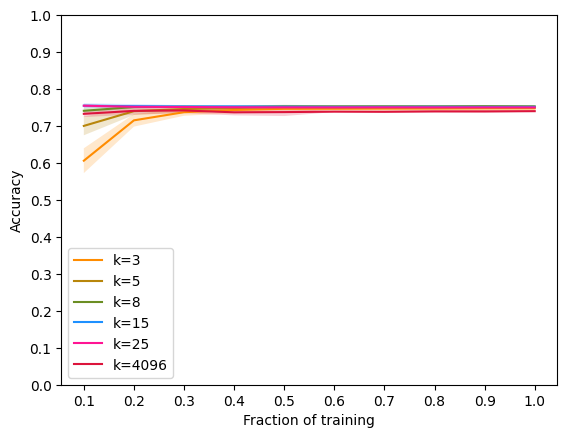

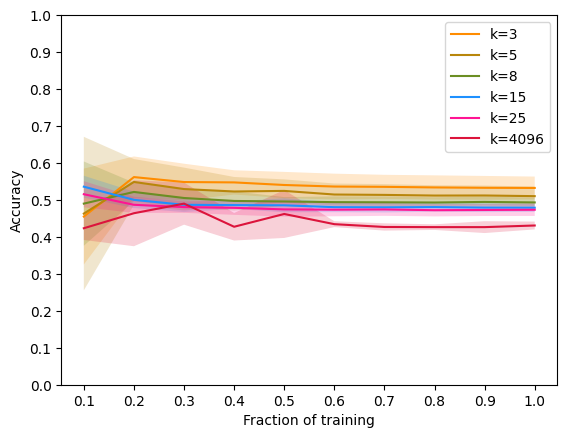

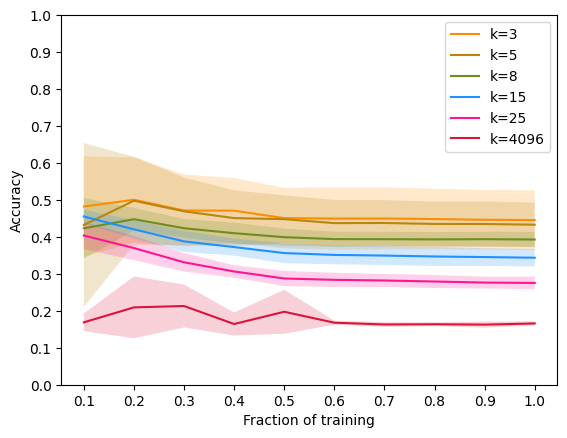

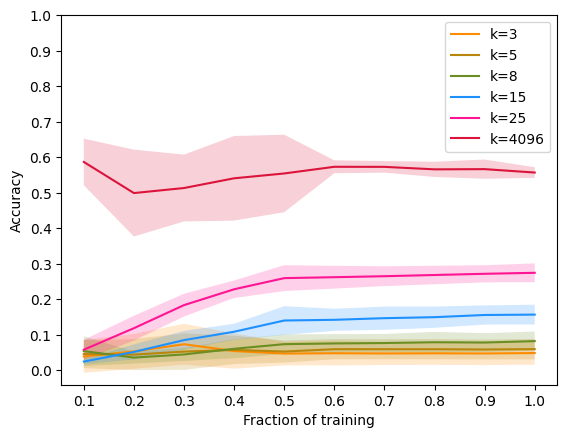

In [ ]:
# Plotting code
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

colors = ['darkorange', 'darkgoldenrod', 'olivedrab', 'dodgerblue', 'deeppink', 'crimson']

num_obs = 10

t = np.arange(num_obs)
per_tr = np.round(np.linspace(0.1, 1, num_obs), 2)

for i in range(4):

    fig, ax = plt.subplots(1)
    lines = []
    for ik, k in enumerate(k_arr):
        mu = np.mean(accuracy_k[ik, :, i, :], axis=0)
        sigma = np.std(accuracy_k[ik, :, i, :], axis=0)
        ax.plot(t, mu, color=colors[ik])
        ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[ik], alpha=0.2)
        lines.append(mlines.Line2D([], [], color=colors[ik], label=f"k={k}"))
    mu = np.mean(accuracy[:, i, :], axis=0)
    sigma = np.std(accuracy[:, i, :], axis=0)
    ax.plot(t, mu, label=f"k={k}", color=colors[-1])
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[-1], alpha=0.2)
    lines.append(mlines.Line2D([], [], color=colors[-1], label=f"k={feature_size}"))
    plt.legend(handles=lines)
    ax.set_xticks(ticks=t, labels=per_tr)
    ax.set_yticks(ticks=np.round(np.linspace(0, 1, 11), 2))
    ax.set_xlabel("Fraction of training")
    ax.set_ylabel("Accuracy")
    plt.savefig(f'dl_cifar10_{i}.png', bbox_inches='tight')
    plt.show()